In [1]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score, save_or_load_onehot, build_data)
# from utils.utils_model import Network, visualize_layers, train, evaluate
from utils.utils_model_full_tensor import Network, visualize_layers, train, evaluate

# from utils.dielectric_utils import cart2realsphvec

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

## load data
data_file = '../dataset/openmx_data_20250312_105926.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')



energy_min = 0 #Unit of energy in eV
energy_max = 20 #Unit of energy in eV
nstep = 201 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (201, 3, 3)


# Apply interpolation efficiently
df['real_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['real_Permittivity_Matrices'], row['omega']) for _, row in df.iterrows()
]

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

perm_matrices_tensor = torch.tensor(np.stack(df['real_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list


## Processed atom feature
def process_atom(Z):
    """Process atomic properties for an element."""
    specie = Atom(Z)
    Z_mass = specie.mass
    Z_dipole = element(specie.symbol).dipole_polarizability or 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko
    return specie.symbol, Z - 1, Z_mass, Z_dipole, Z_radius


type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

# Find the scaling value
tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print(tmp.shape)
# mean_data = np.mean(np.max(tmp, axis=1))
# std_data = np.std(np.max(tmp, axis=1))
# print(mean_data)
# print(std_data) 
# scale_data = np.median(np.max(tmp, axis=1))
scale_data = 1
print(scale_data)


r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data, type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding, r_max), axis=1)


torch device: cuda:0
data acquired
Loading existing data...
(1525, 201, 6)
1


100%|██████████| 1525/1525 [00:22<00:00, 67.71it/s]


In [7]:
df["data"].iloc[0]

Data(edge_index=[2, 528], y=[1, 201, 6], pos=[16, 3], lattice=[1, 3, 3], symbol=[16], x_mass=[16, 118], x_dipole=[16, 118], x_radius=[16, 118], z=[16, 118], edge_shift=[528, 3], edge_vec=[528, 3], edge_len=[528])

split train/dev ...


  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 732.58it/s]


split valid/test ...


100%|██████████| 65/65 [00:00<00:00, 997.53it/s]

number of training examples: 1214
number of validation examples: 143
number of testing examples: 168
total number of examples: 1525


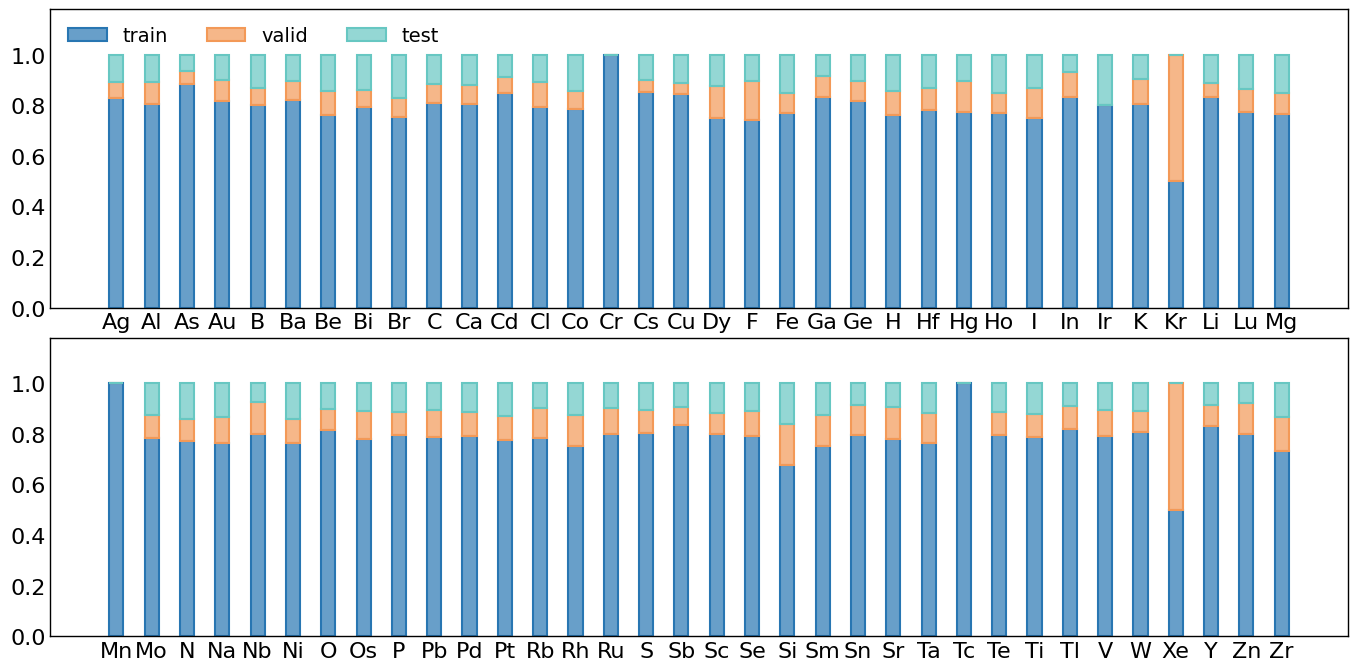

In [3]:
run_time = time.strftime('%y%m%d', time.localtime())
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)
#Save train loss values sets
np.savetxt('../model/idx_train_'+ run_time +'.txt', idx_train, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_valid_'+ run_time +'.txt', idx_valid, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_test_'+ run_time +'.txt', idx_test, fmt='%i', delimiter='\t')
# load train/valid/test indices
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

In [4]:
## NN part
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em_type = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_type(data.z))
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)      # stack the atom features in shape (3, N, em_dim) 
        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
            # output = torch_scatter.scatter_add(output, data.batch, dim=0)  # take mean over atoms per example
            # output, _ = torch_scatter.scatter_max(output, data.batch, dim=0)  # max over atoms per examples

        # normalization output from 0 to 1
        # maxima, _ = torch.max(output, dim=1)
        # output = output.div(maxima.unsqueeze(1))
        return output

out_dim = len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e +" +  str(out_dim) + "x2e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=2,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

In [5]:
model.to(device)

total_params = sum(param.numel() for param in model.parameters())
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

for name, param in model.named_parameters():
    print(f"{name}: {param.shape} requires_grad={param.requires_grad}")
    
run_name = 'model_re_sph_coefs_' + run_time
opt = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name, max_iter=5, scheduler=scheduler, device=device)


# Output MSE.txt
history = torch.load('../model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]
# np.savetxt(run_name+'_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
save_pdf_dir = "../pdfs"
save_path = os.path.join(save_pdf_dir, run_name + '_loss.pdf')
fig.savefig(save_path)

Total parameters: 8720827
Trainable parameters: 8720827
layers.0.first.sc.weight: torch.Size([393216]) requires_grad=True
layers.0.first.lin1.weight: torch.Size([262144]) requires_grad=True
layers.0.first.fc.layer0.weight: torch.Size([10, 100]) requires_grad=True
layers.0.first.fc.layer1.weight: torch.Size([100, 192]) requires_grad=True
layers.0.first.lin2.weight: torch.Size([655360]) requires_grad=True
layers.1.first.sc.weight: torch.Size([458752]) requires_grad=True
layers.1.first.lin1.weight: torch.Size([196608]) requires_grad=True
layers.1.first.fc.layer0.weight: torch.Size([10, 100]) requires_grad=True
layers.1.first.fc.layer1.weight: torch.Size([100, 480]) requires_grad=True
layers.1.first.lin2.weight: torch.Size([1769472]) requires_grad=True
layers.2.sc.weight: torch.Size([823296]) requires_grad=True
layers.2.lin1.weight: torch.Size([327680]) requires_grad=True
layers.2.fc.layer0.weight: torch.Size([10, 100]) requires_grad=True
layers.2.fc.layer1.weight: torch.Size([100, 288]) r

  0%|          | 0/1214 [00:00<?, ?it/s]

torch.Size([1, 1206])
torch.Size([1, 1005])


AttributeError: 'GlobalStorage' object has no attribute 'sph_coefs'